# Text Mining: Predicting Airbnb Unlisting

**University:** NOVA Information Management School<br/>
**Program:** Master’s Degree Program in Data Science and Advanced Analytics<br/>
**Academic Year:** 2022/2023

```
============== Students: ==================
Iryna Savchuk (m20211310@novaims.unl.pt)
Cátia Parrinha (m20201320@novaims.unl.pt)
Pedro Anastácio (m20180040@novaims.unl.pt)
===========================================
```

## Importing Libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from langdetect import detect

import demoji
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import string
import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import MinMaxScaler

## Importing Data - "Train"

In [2]:
df_train_raw = pd.read_excel('Project Corpora/train.xlsx')

In [3]:
df_train_raw.head(5)

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


## Initial Exploratory Analysis - "Train"

### Checking the dataset shape

In [4]:
df_train_raw.shape

(12496, 4)

### Checking for empty values

In [5]:
# Count the number of empty values in each column
empty_counts = df_train_raw.isna().sum()
print(empty_counts) 

index          0
description    0
host_about     0
unlisted       0
dtype: int64


### Checking label proportion

In [6]:
df_train_raw['unlisted'].value_counts()

unlisted
0    9033
1    3463
Name: count, dtype: int64

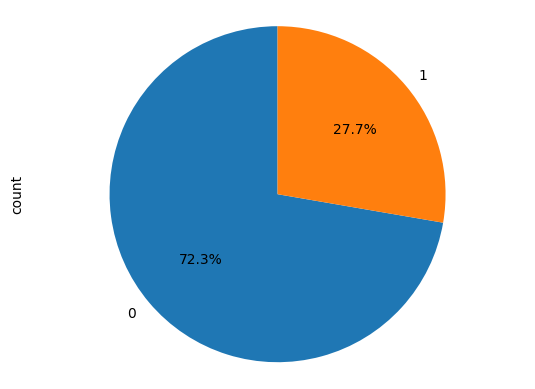

In [7]:
#df_train['unlisted'].pie()  # Classes are imbalanced !!!
# plot a pie chart for the 'count' column
df_train_raw['unlisted'].value_counts().plot(kind='pie', 
                                             labels=df_train_raw['unlisted'].unique(), 
                                             autopct='%1.1f%%', 
                                             startangle=90)
plt.axis('equal')
plt.show()

### Exploring 'description' column

In [8]:
df_train_raw['description'].str.len().describe()

count    12496.000000
mean       814.679097
std        282.124598
min         12.000000
25%        625.000000
50%       1000.000000
75%       1000.000000
max       1000.000000
Name: description, dtype: float64

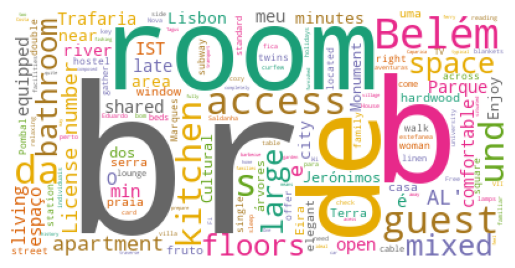

In [9]:
wordcloud = WordCloud(
    background_color='white', 
    max_words=500, 
    colormap='Dark2',
    contour_width=4).generate(str(df_train_raw['description'].values))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Exploring 'host_about' column

In [10]:
df_train_raw['host_about'].str.len().describe()

count    12496.000000
mean       439.562100
std        486.270567
min          1.000000
25%        152.000000
50%        325.000000
75%        612.000000
max       8683.000000
Name: host_about, dtype: float64

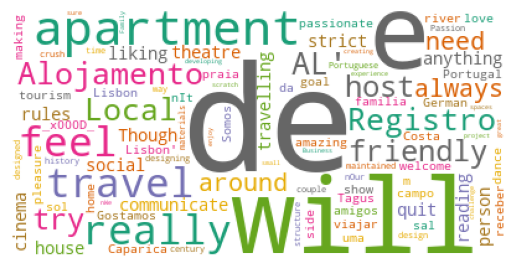

In [11]:
wordcloud = WordCloud(
    background_color='white', 
    max_words=500,
    colormap='Dark2',
    contour_width=4).generate(str(df_train_raw['host_about'].values))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Checking for duplications

In [12]:
duplicated_descriptions = df_train_raw['description'][df_train_raw['description'].duplicated(keep=False)].unique()
duplicated_host_abouts = df_train_raw['host_about'][df_train_raw['host_about'].duplicated(keep=False)].unique()

print('The number of unique duplicated descriptions:', len(duplicated_descriptions))
print('The number of unique duplicated host_about values:', len(duplicated_host_abouts))

The number of unique duplicated descriptions: 365
The number of unique duplicated host_about values: 1673


In [13]:
duplicated_1 = "Saldanha Prestige is a classy and quality apartment that has been totally renovated this year in order to prepare the 9 rooms and all the common areas to welcome our Guests with all the best confort. From here you'll be able to enjoy all the best Lisboa has to offer! Come and stay with us - you're always welcome! I've been a proud Airbnb host for 2 years and have very good reviews.<br /><br /><b>The space</b><br />The apartment was totally renovated this year and has 7 rooms with shared bathrooms and 2 with their own private bathrooms. Included in the price are the common expenses, Wi-fi internet throughout the apartment, cleaning service of all common areas three times a week and also of the rooms once a week. Rooms are confortably furnished with good beds and guests are supplied with bath towels and bed linens.<br /><br /><b>Guest access</b><br />All the rooms have access to a beautiful living room with TV, a completely equiped kitchen with all equipments: tableware, fridges, freezer"

In [14]:
df_train_raw.loc[df_train_raw['description']==duplicated_1]

,index,description,host_about,unlisted
98,99,Saldanha Prestige is a classy and quality apar...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0
3581,3582,Saldanha Prestige is a classy and quality apar...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0
4090,4091,Saldanha Prestige is a classy and quality apar...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0
4859,4860,Saldanha Prestige is a classy and quality apar...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0
5381,5382,Saldanha Prestige is a classy and quality apar...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0
6649,6650,Saldanha Prestige is a classy and quality apar...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0
7378,7379,Saldanha Prestige is a classy and quality apar...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0
8873,8874,Saldanha Prestige is a classy and quality apar...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0


In [15]:
duplicated_2 = '<b>Other things to note</b><br />For your information, we are carrying out work in the apartment and because of this the kitchen will not be available, for the month of February there will be men working from 9 am to 5 pm. To compensate, you pay much less than -50% of the price usual.<br /><br /><b>License number</b><br />104691/AL'

In [16]:
df_train_raw.loc[df_train_raw['description']==duplicated_2]

,index,description,host_about,unlisted
92,93,<b>Other things to note</b><br />For your info...,.,1
5352,5353,<b>Other things to note</b><br />For your info...,.,0
9285,9286,<b>Other things to note</b><br />For your info...,.,1


### Summary of Exploratory Analysis

The original 'train' dataset contains 12496 rows and 4 columns: 'index', 'description', 'host_about', 'unlisted'. The 'unlisted' column is the target variable and is to be predicted based on other values.

Based on the wordclouds, it can be seen that the given dataset contains languages other then English - at least Portuguese(see the words like 'de', 'e', 'Alojamento', 'Belém', 'praia') and German('und', 'ist' and others). Also, there is a number of tags (such as "\<br />" and "\<b>") in our data as well as sequences of characters that are obtained after import from an Excel file (such as "_x000D_\n"). 
 
The dataset does not have any empty values. 

It turned out, some rows have the same values for both 'description' and 'host_about' columns, wheras 'unlisted' values are different. It means that using only 'train' dataset might be not enough for the project purpose and we might want to utilize 'reviews' data as well.